In [1]:
!pip install XGBoost
!pip install catboost
!pip install optuna
!pip install LightGBM
!pip install optuna-integration[lightgbm]
import pandas as pd
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


In [15]:
from sklearn.model_selection import train_test_split
df_m_train = pd.read_csv("train_Mortgage.csv")
df_p_train = pd.read_csv("train_Pension.csv")
df_s_train = pd.read_csv("train_Savings.csv")
target_name_1 = "Mortgage"
target_name_2 = "Pension"
target_name_3 = "Savings"
y_train_m = df_m_train[target_name_1]
y_train_p = df_p_train[target_name_2]
y_train_s = df_s_train[target_name_3]
X_train_m = df_m_train.drop(columns=[target_name_1])
X_train_p = df_p_train.drop(columns=[target_name_2])
X_train_s = df_s_train.drop(columns=[target_name_3])

In [16]:
df_m_valid = pd.read_csv("val_Mortgage.csv")
df_p_valid = pd.read_csv("val_Pension.csv")
df_s_valid = pd.read_csv("val_Savings.csv")
y_test_m = df_m_valid[target_name_1]
y_test_p = df_p_valid[target_name_2]
y_test_s = df_s_valid[target_name_3]
X_test_m = df_m_valid.drop(columns=[target_name_1])
X_test_p = df_p_valid.drop(columns=[target_name_2])
X_test_s = df_s_valid.drop(columns=[target_name_3])

In [62]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    roc_curve,
)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def evaluate_models(model_1, model_2, model_3, X_test, y_test,target, pos_label='yes'):
    """
    Вычисляет метрики и строит график AUC для модели CatBoostClassifier.

    Параметры:
        model1:
        model2:
        model3:
        X_test: Тестовые данные (признаки).
        y_test: Истинные значения целевой переменной.

    Возвращает:
        Словарь с метриками: accuracy, f1_score, roc_auc, precision, recall.
    """

    # Предсказание вероятностей и классов
    y_pred_proba_1 = model_1.predict_proba(X_test)[:, 1]  # Вероятности для положительного класса
    y_pred_1 = model_1.predict(X_test)  # Предсказанные классы
    y_pred_proba_2 = model_2.predict_proba(X_test)[:, 1]  # Вероятности для положительного класса
    y_pred_2 = model_2.predict(X_test)  # Предсказанные классы
    y_pred_proba_3 = model_3.predict_proba(X_test)[:, 1]  # Вероятности для положительного класса
    y_pred_3 = model_3.predict(X_test)  # Предсказанные классы

    fpr1, tpr1, _ = roc_curve(y_test, y_pred_proba_1)
    roc_auc_1 = auc(fpr1, tpr1)
    fpr2, tpr2, _ = roc_curve(y_test, y_pred_proba_2)
    roc_auc_2 = auc(fpr2, tpr2)
    fpr3, tpr3, _ = roc_curve(y_test, y_pred_proba_3)
    roc_auc_3 = auc(fpr3, tpr3)
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 7))
    sns.lineplot(x=fpr1, y=tpr1, label=f'LightGBM (AUC = {roc_auc_1:.6f})', color='blue')
    sns.lineplot(x=fpr2, y=tpr2, label=f'CatBoost (AUC = {roc_auc_2:.6f})', color='green')
    sns.lineplot(x=fpr3, y=tpr3, label=f'XGBoost (AUC = {roc_auc_3:.6f})', color='red')

    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

    # Настраиваем график
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC for ' + target)
    plt.legend(loc='lower right')
    plt.show()

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch

targets = {
    "Mortgage": (df_m_train, "Mortgage"),
    "Pension": (df_p_train, "Pension"),
    "Savings": (df_s_train, "Savings")
}

# Разделение данных для каждого таргета
datasets = {}
for name, (df, target) in targets.items():
    y = df[target]
    X = df.drop(columns=[target])

    # Разделение на train/val
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Нормализация числовых признаков
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    datasets[name] = {
        "X_train": torch.FloatTensor(X_train),
        "X_val": torch.FloatTensor(X_val),
        "y_train": torch.FloatTensor(y_train.values).view(-1, 1),
        "y_val": torch.FloatTensor(y_val.values).view(-1, 1)
    }

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np

class FiNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, top_k=5):
        super().__init__()
        self.input_dim = input_dim
        self.top_k = top_k

        # Слой для обучения взаимодействий
        self.interaction = nn.Linear(input_dim * input_dim, hidden_dim)

        # Полносвязные слои
        self.fc1 = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

        # Для хранения топовых взаимодействий
        self.top_interactions = None

    def forward(self, x):
        batch_size = x.shape[0]
        interactions = torch.bmm(x.unsqueeze(2), x.unsqueeze(1))  # [batch, dim, dim]
        interactions = interactions.view(batch_size, -1)  # [batch, dim*dim]
        interaction_features = F.relu(self.interaction(interactions))
        combined = torch.cat([x, interaction_features], dim=1)
        out = F.relu(self.fc1(combined))
        out = torch.sigmoid(self.fc2(out))
        return out

    def get_top_interactions(self):
        """Возвращает топ-5 пар признаков по весам interaction-слоя."""
        weights = self.interaction.weight.detach().cpu().numpy()  # [hidden_dim, dim*dim]
        mean_weights = np.mean(np.abs(weights), axis=0)  # Усредняем по hidden_dim
        mean_weights = mean_weights.reshape(self.input_dim, self.input_dim)

        # Находим топ-5 пар (i, j) с максимальными весами (исключаем диагональ)
        indices = np.unravel_index(
            np.argsort(-mean_weights, axis=None),
            mean_weights.shape
        )
        top_pairs = []
        for i, j in zip(*indices):
            if i != j and (j, i) not in top_pairs:  # Исключаем повторы и диагональ
                top_pairs.append((i, j))
                if len(top_pairs) == self.top_k:
                    break
        self.top_interactions = top_pairs
        return top_pairs

    def add_interactions_to_data(self, X):
        """Добавляет топ-5 взаимодействий в датасет."""
        if self.top_interactions is None:
            self.get_top_interactions()

        X_new = X.copy()
        feature_names = X.columns if isinstance(X, pd.DataFrame) else [f"f_{i}" for i in range(X.shape[1])]

        for i, j in self.top_interactions:
            f1, f2 = feature_names[i], feature_names[j]
            X_new[f"{f1}_x_{f2}"] = X.iloc[:, i] * X.iloc[:, j]  # Для pandas
            # Или так для numpy: X_new[:, i] * X_new[:, j]

        return X_new

In [69]:
# 1. Создаём и обучаем модель
input_dim = datasets['Mortgage']["X_train"].shape[1]  # Число признаков в данных
model = FiNet(input_dim=input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Пример данных (замените на свои)
X_tensor = datasets['Mortgage']["X_train"]  # [batch_size, input_dim]
y_tensor = datasets['Mortgage']["y_train"]

# Обучение (упрощённый пример)
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()

# 2. Извлекаем топ-5 взаимодействий
top_pairs = model.get_top_interactions()
print("Топ-5 взаимодействий:", top_pairs)

# 3. Добавляем их в датасет
X_new_train_m = model.add_interactions_to_data(X_train_m)
X_new_test_m = model.add_interactions_to_data(X_test_m)

Топ-5 взаимодействий: [(13, 4), (13, 17), (7, 13), (6, 13), (13, 3)]


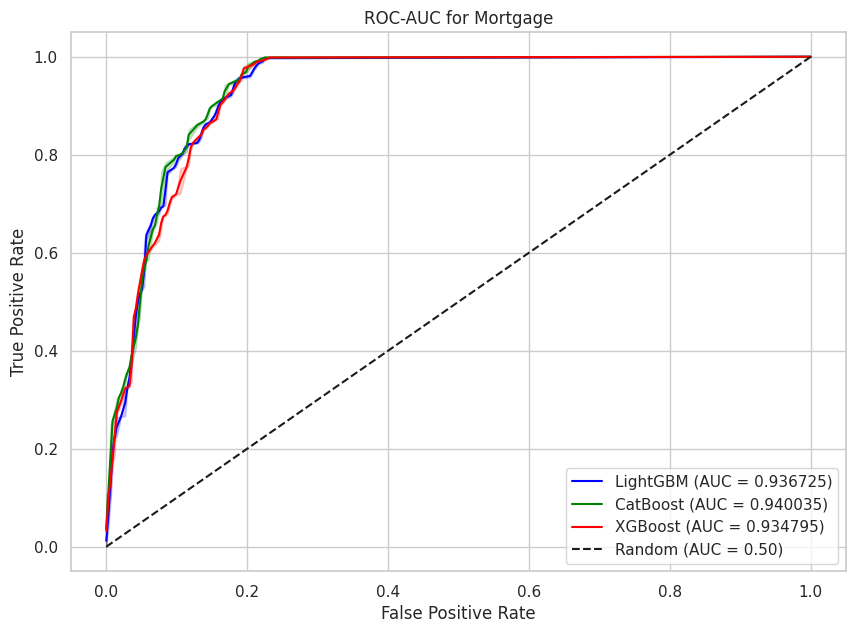

In [63]:
default_model_m_l = LGBMClassifier(verbose=0)
default_model_m_l.fit(X_new_train_m,  y_train_m)
default_model_m = XGBClassifier()
default_model_m.fit(X_new_train_m, y_train_m)
default_model_m_c = CatBoostClassifier(verbose=0)
default_model_m_c.fit(X_new_train_m, y_train_m, verbose=False)
evaluate_models(default_model_m_l, default_model_m_c, default_model_m, X_new_test, y_test_m, "Mortgage", pos_label=1)

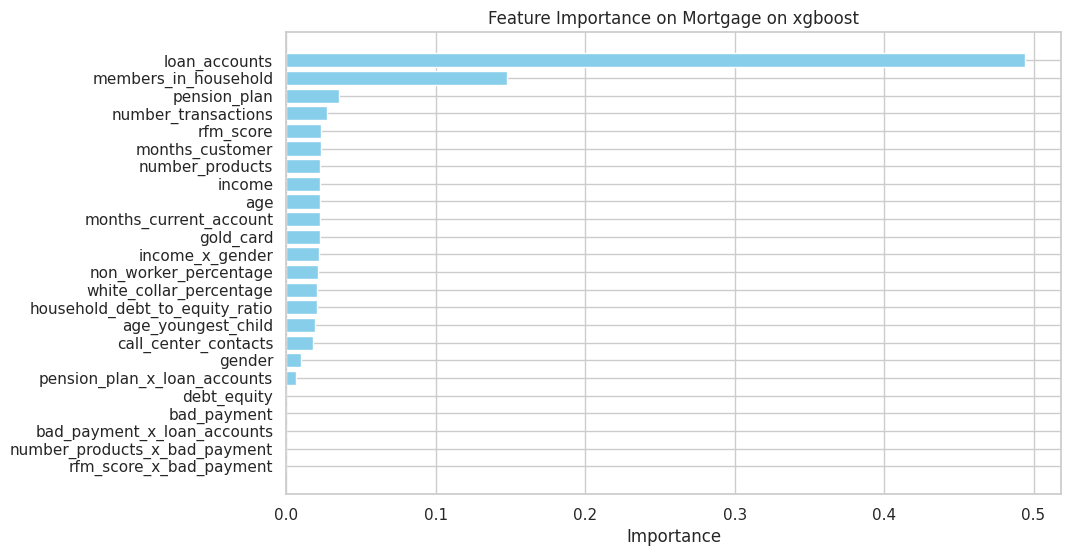

In [65]:
importances_xg = default_model_m.feature_importances_
fi_df_xg = pd.DataFrame({"Feature": X_new_test.columns, "Importance": importances_xg})
fi_df_xg = fi_df_xg.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_df_xg["Feature"], fi_df_xg["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance on Mortgage on xgboost")
plt.show()

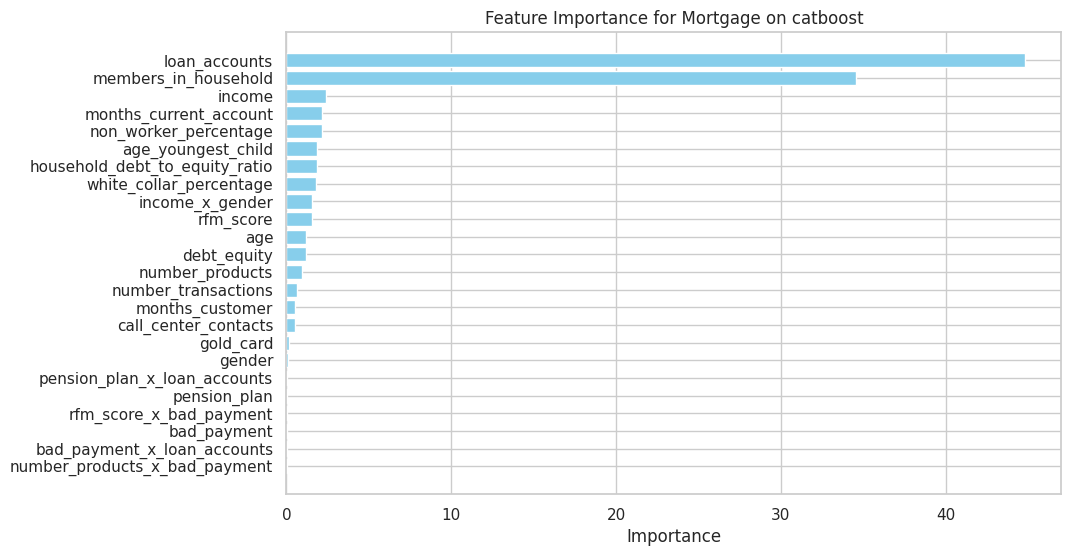

In [67]:
importance_c = default_model_m_c.get_feature_importance()
fi_df_c = pd.DataFrame({"Feature": X_new_test_m.columns, "Importance": importance_c})
fi_df_c = fi_df_c.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_df_c["Feature"], fi_df_c["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance for Mortgage on catboost")
plt.show()

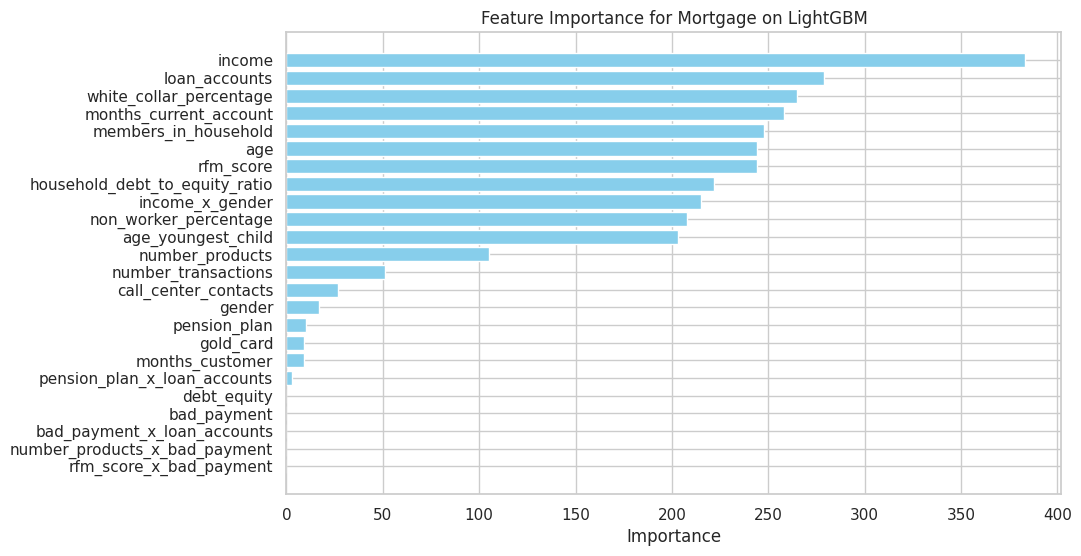

In [68]:
importance_l = default_model_m_l.feature_importances_
fi_df_l = pd.DataFrame({"Feature": X_new_test.columns, "Importance": importance_l})
fi_df_l = fi_df_l.sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10,6))
plt.barh(fi_df_l["Feature"], fi_df_l["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance for Mortgage on LightGBM")
plt.show()

In [70]:
# 1. Создаём и обучаем модель
input_dim = datasets['Pension']["X_train"].shape[1]  # Число признаков в данных
model = FiNet(input_dim=input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Пример данных (замените на свои)
X_tensor = datasets['Pension']["X_train"]  # [batch_size, input_dim]
y_tensor = datasets['Pension']["y_train"]

# Обучение (упрощённый пример)
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()

# 2. Извлекаем топ-5 взаимодействий
top_pairs = model.get_top_interactions()
print("Топ-5 взаимодействий:", top_pairs)

# 3. Добавляем их в датасет
X_new_train_p = model.add_interactions_to_data(X_train_p)
X_new_test_p = model.add_interactions_to_data(X_test_p)

Топ-5 взаимодействий: [(5, 8), (4, 16), (4, 9), (9, 6), (8, 9)]


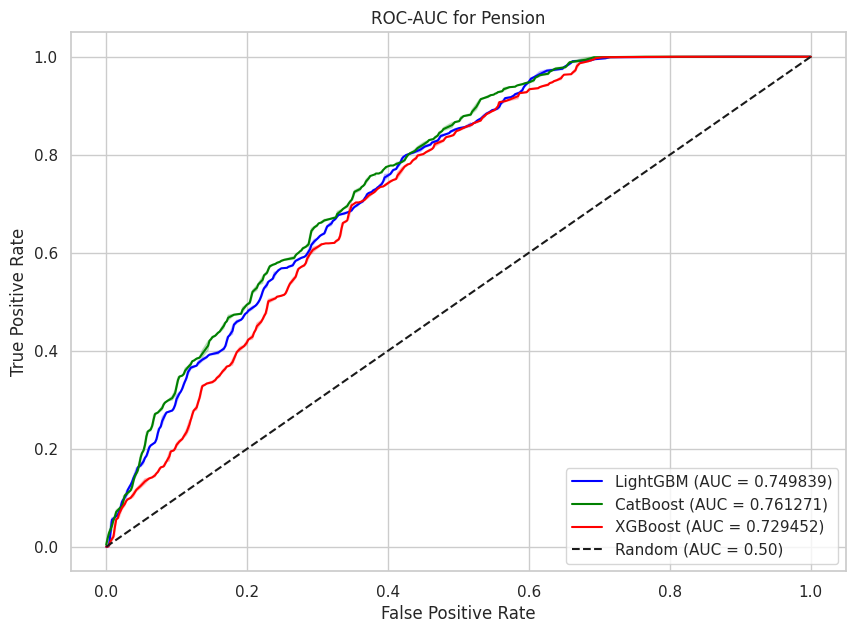

In [71]:
default_model_p_l = LGBMClassifier(verbose=0)
default_model_p_l.fit(X_new_train_p,y_train_p)
default_model_p_x = XGBClassifier()
default_model_p_x.fit(X_new_train_p, y_train_p)
default_model_p_c = CatBoostClassifier(verbose=0)
default_model_p_c.fit(X_new_train_p, y_train_p, verbose=False)
evaluate_models(default_model_p_l, default_model_p_c, default_model_p_x, X_new_test_p, y_test_p,'Pension',  pos_label=1)

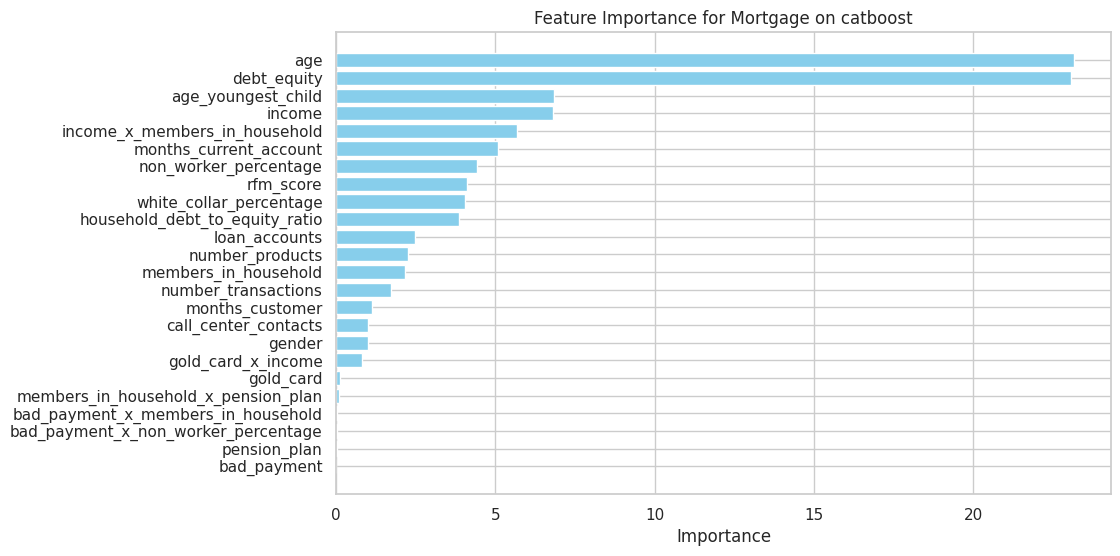

In [72]:
importance_c = default_model_p_c.get_feature_importance()
fi_df_c = pd.DataFrame({"Feature": X_new_test_p.columns, "Importance": importance_c})
fi_df_c = fi_df_c.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_df_c["Feature"], fi_df_c["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance for Mortgage on catboost")
plt.show()

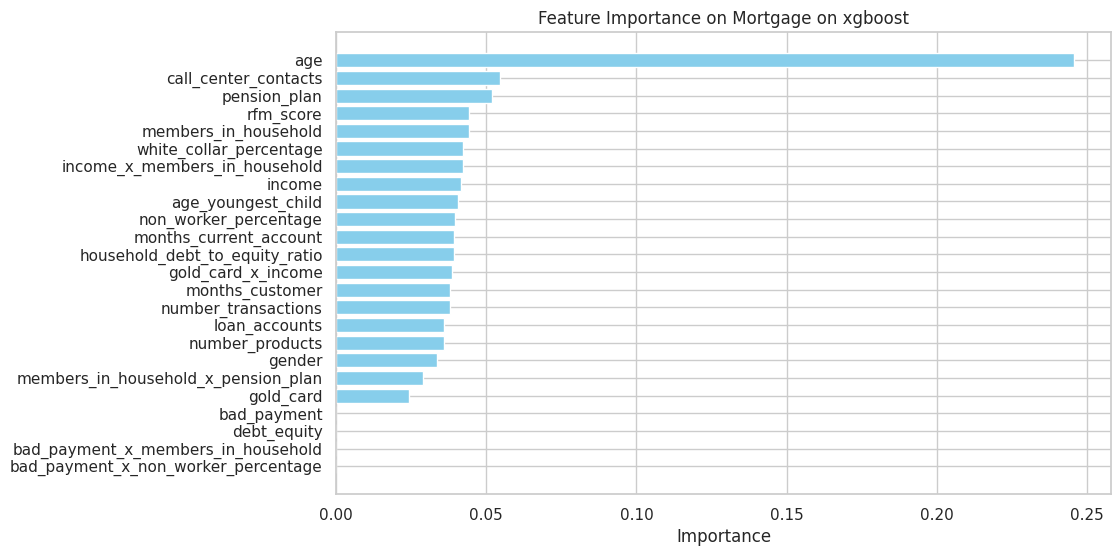

In [73]:
importances_xg = default_model_p_x.feature_importances_
fi_df_xg = pd.DataFrame({"Feature": X_new_test_p.columns, "Importance": importances_xg})
fi_df_xg = fi_df_xg.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_df_xg["Feature"], fi_df_xg["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance on Mortgage on xgboost")
plt.show()

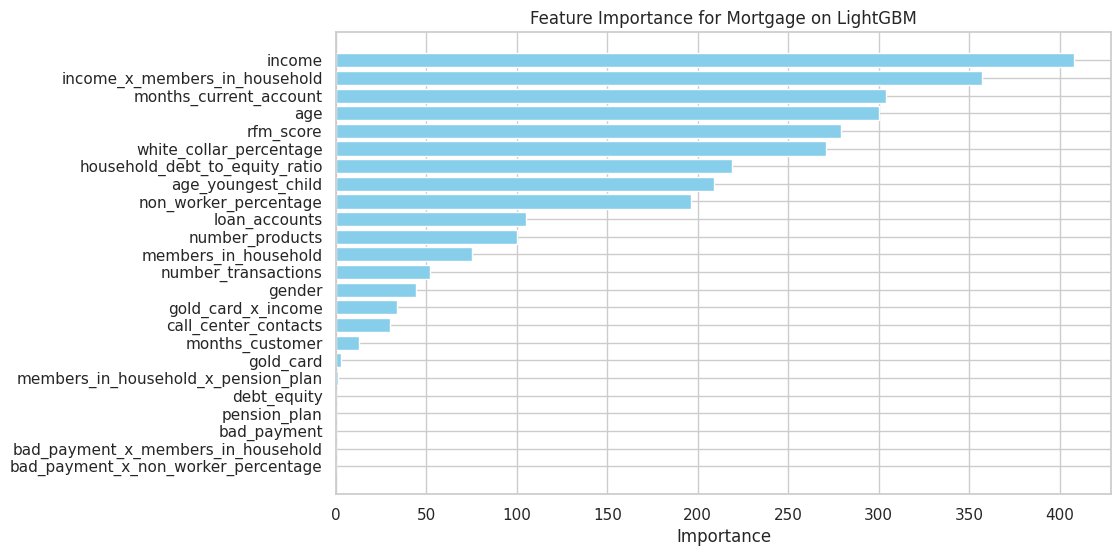

In [74]:
importance_l = default_model_p_l.feature_importances_
fi_df_l = pd.DataFrame({"Feature": X_new_test_p.columns, "Importance": importance_l})
fi_df_l = fi_df_l.sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10,6))
plt.barh(fi_df_l["Feature"], fi_df_l["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance for Mortgage on LightGBM")
plt.show()

In [75]:
# 1. Создаём и обучаем модель
input_dim = datasets['Savings']["X_train"].shape[1]  # Число признаков в данных
model = FiNet(input_dim=input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Пример данных (замените на свои)
X_tensor = datasets['Savings']["X_train"]  # [batch_size, input_dim]
y_tensor = datasets['Savings']["y_train"]

# Обучение (упрощённый пример)
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()

# 2. Извлекаем топ-5 взаимодействий
top_pairs = model.get_top_interactions()
print("Топ-5 взаимодействий:", top_pairs)

# 3. Добавляем их в датасет
X_new_train_s = model.add_interactions_to_data(X_train_s)
X_new_test_s = model.add_interactions_to_data(X_test_s)

Топ-5 взаимодействий: [(5, 16), (8, 5), (3, 5), (10, 3), (13, 3)]


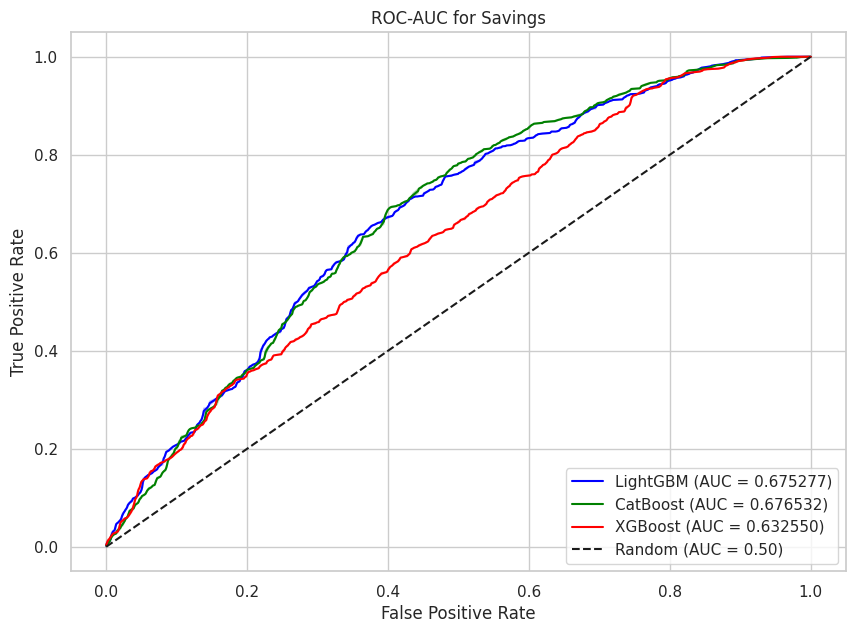

In [77]:
default_model_s_l = LGBMClassifier(verbose=0)
default_model_s_l.fit(X_new_train_s, y_train_s)
default_model_s_x = XGBClassifier()
default_model_s_x.fit(X_new_train_s,y_train_s)
default_model_s_c = CatBoostClassifier(verbose=0)
default_model_s_c.fit(X_new_train_s, y_train_s, verbose=False)
evaluate_models(default_model_s_l, default_model_s_c, default_model_s_x, X_new_test_s, y_test_s, "Savings", pos_label=1)

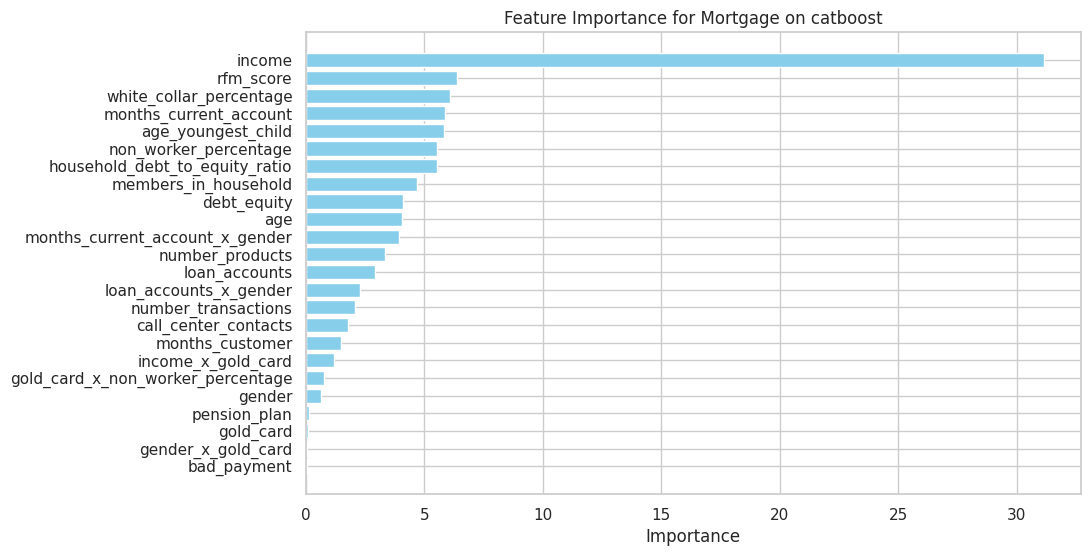

In [137]:
importance_c = default_model_s_c.get_feature_importance()
fi_df_c = pd.DataFrame({"Feature": X_new_test_s.columns, "Importance": importance_c})
fi_df_c = fi_df_c.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_df_c["Feature"], fi_df_c["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance for Mortgage on catboost")
plt.show()

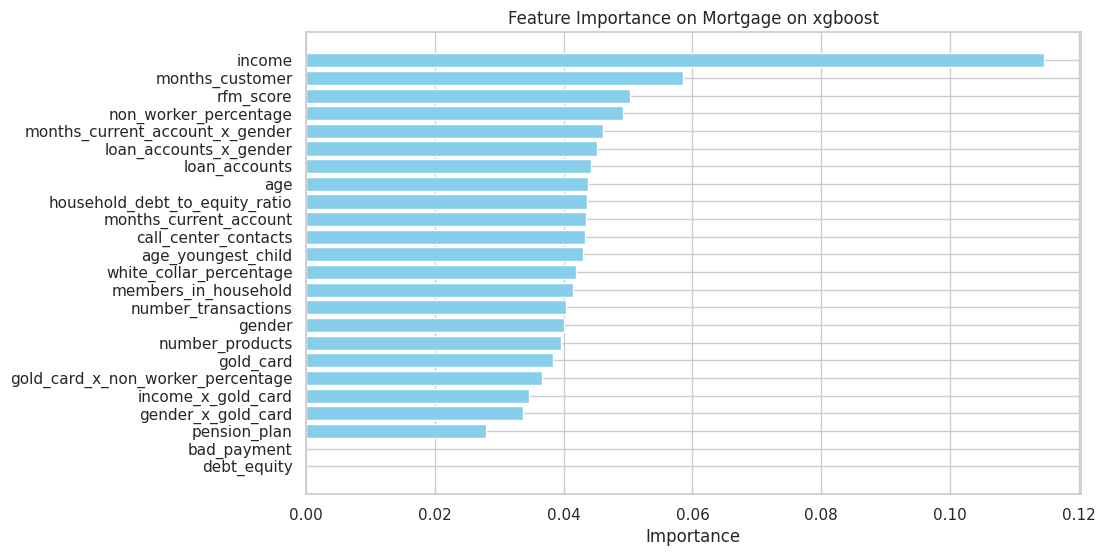

In [138]:
importances_xg = default_model_s_x.feature_importances_
fi_df_xg = pd.DataFrame({"Feature": X_new_test_s.columns, "Importance": importances_xg})
fi_df_xg = fi_df_xg.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_df_xg["Feature"], fi_df_xg["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance on Mortgage on xgboost")
plt.show()

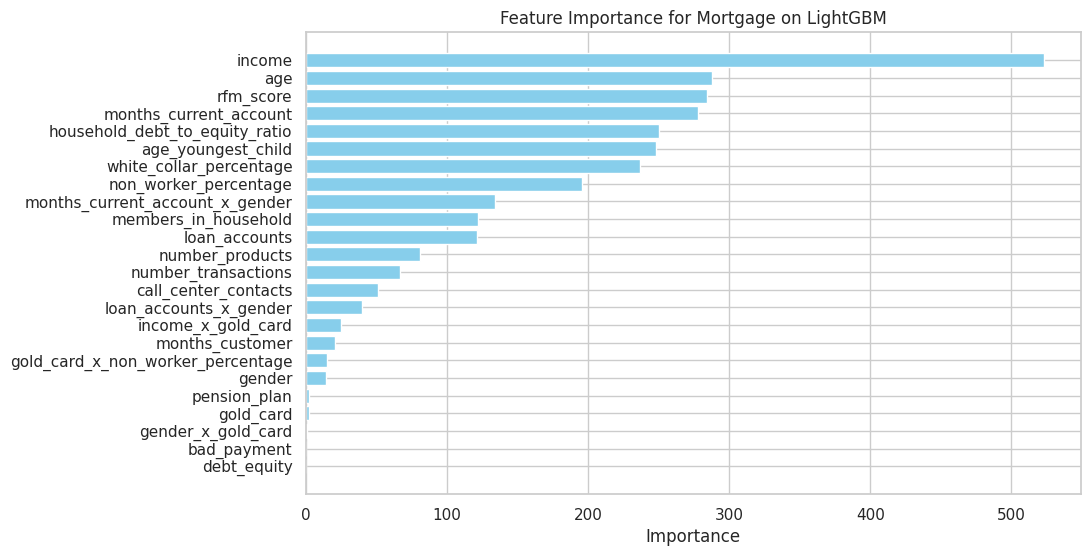

In [139]:
importance_l = default_model_s_l.feature_importances_
fi_df_l = pd.DataFrame({"Feature": X_new_test_s.columns, "Importance": importance_l})
fi_df_l = fi_df_l.sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10,6))
plt.barh(fi_df_l["Feature"], fi_df_l["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance for Mortgage on LightGBM")
plt.show()

In [140]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    roc_curve,
)
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, pos_label='yes'):
    """
    Вычисляет метрики и строит график AUC для модели CatBoostClassifier.

    Параметры:
        model: Обученная модель CatBoostClassifier.
        X_test: Тестовые данные (признаки).
        y_test: Истинные значения целевой переменной.

    Возвращает:
        Словарь с метриками: accuracy, f1_score, roc_auc, precision, recall.
    """
    # Предсказание вероятностей и классов
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Вероятности для положительного класса
    y_pred = model.predict(X_test)  # Предсказанные классы

    # Вычисление метрик
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label=pos_label)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, pos_label=pos_label)
    recall = recall_score(y_test, y_pred, pos_label=pos_label)
    # Возвращение метрик
    return {
        "accuracy": accuracy,
        "f1_score": f1,
        "roc_auc": roc_auc,
        "precision": precision,
        "recall": recall,
    }

In [124]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
X_train_m, X_valid_m, y_train_m, y_valid_m = train_test_split(X_new_train_m, y_train_m, test_size = 0.15, stratify=y_train_m)
X_train_p, X_valid_p, y_train_p, y_valid_p = train_test_split(X_new_train_p, y_train_p, test_size = 0.15, stratify=y_train_p)
X_train_s, X_valid_s, y_train_s, y_valid_s = train_test_split(X_new_train_s, y_train_s, test_size = 0.15, stratify=y_train_s)

In [126]:
X_m = pd.concat([X_train_m, X_valid_m, X_new_test_m], ignore_index=True)
y_m = pd.concat([y_train_m, y_valid_m, y_test_m], ignore_index=True)
X_p = pd.concat([X_train_p, X_valid_p, X_new_test_p], ignore_index=True)
y_p = pd.concat([y_train_p, y_valid_p, y_test_p], ignore_index=True)
X_s = pd.concat([X_train_s, X_valid_s, X_new_test_s], ignore_index=True)
y_s = pd.concat([y_train_s, y_valid_s, y_test_s], ignore_index=True)

In [127]:
default_model_m_l = LGBMClassifier(verbose=0)
default_model_m_x = XGBClassifier()
default_model_m_c = CatBoostClassifier(verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(default_model_m_c, X_m, y_m, cv=kfold, scoring='roc_auc')
print("roc-auc для каждого фолда:", scores)
print("Средняя roc-auc Catboost:", scores.mean())
scores = cross_val_score(default_model_m_l, X_m, y_m, cv=kfold, scoring='roc_auc')
print("roc-auc для каждого фолда:", scores)
print("Средняя roc-auc LightGBM:", scores.mean())
scores = cross_val_score(default_model_m_x, X_m, y_m, cv=kfold, scoring='roc_auc')
print("roc-auc для каждого фолда:", scores)
print("Средняя roc-auc XGBoost:", scores.mean())

roc-auc для каждого фолда: [0.94726696 0.93777121 0.94391258 0.94200498 0.94637052]
Средняя roc-auc Catboost: 0.9434652517583988
roc-auc для каждого фолда: [0.94469021 0.9331995  0.94225555 0.94140016 0.94490879]
Средняя roc-auc LightGBM: 0.9412908448151723
roc-auc для каждого фолда: [0.93796418 0.93141959 0.93846532 0.93771937 0.93685291]
Средняя roc-auc XGBoost: 0.9364842737693475


In [135]:
default_model_l = LGBMClassifier(verbose=0)
default_model_x = XGBClassifier()
default_model_c = CatBoostClassifier(verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(default_model_c, X_p, y_p, cv=kfold, scoring='roc_auc')
print("roc-auc для каждого фолда:", scores)
print("Средняя roc-auc Catboost:", scores.mean())
scores = cross_val_score(default_model_l, X_p, y_p, cv=kfold, scoring='roc_auc')
print("roc-auc для каждого фолда:", scores)
print("Средняя roc-auc LightGBM:", scores.mean())
scores = cross_val_score(default_model_x, X_p, y_p, cv=kfold, scoring='roc_auc')
print("roc-auc для каждого фолда:", scores)
print("Средняя roc-auc XGBoost:", scores.mean())

roc-auc для каждого фолда: [0.758391   0.75206681 0.7695649  0.76714905 0.7407242 ]
Средняя roc-auc Catboost: 0.7575791926435175
roc-auc для каждого фолда: [0.74850023 0.74250741 0.76529471 0.7568382  0.74043068]
Средняя roc-auc LightGBM: 0.7507142448975451
roc-auc для каждого фолда: [0.72928298 0.72165417 0.75103531 0.72641031 0.72893752]
Средняя roc-auc XGBoost: 0.7314640598269196


In [134]:
default_model_l = LGBMClassifier(verbose=0)
default_model_x = XGBClassifier()
default_model_c = CatBoostClassifier(verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(default_model_c, X_s, y_s, cv=kfold, scoring='roc_auc')
print("roc-auc для каждого фолда:", scores)
print("Средняя roc-auc Catboost:", scores.mean())
scores = cross_val_score(default_model_l, X_s, y_s, cv=kfold, scoring='roc_auc')
print("roc-auc для каждого фолда:", scores)
print("Средняя roc-auc LightGBM:", scores.mean())
scores = cross_val_score(default_model_x, X_s, y_s, cv=kfold, scoring='roc_auc')
print("roc-auc для каждого фолда:", scores)
print("Средняя roc-auc XGBoost:", scores.mean())

roc-auc для каждого фолда: [0.64096727 0.67536541 0.66320431 0.64698494 0.68066223]
Средняя roc-auc Catboost: 0.6614368305992363
roc-auc для каждого фолда: [0.63102625 0.6691498  0.65395639 0.6343731  0.66568637]
Средняя roc-auc LightGBM: 0.6508383836315751
roc-auc для каждого фолда: [0.62688848 0.64538984 0.63024558 0.61360127 0.6301602 ]
Средняя roc-auc XGBoost: 0.629257073919387


In [147]:
def optimizers(model_lib,X_train, y_train, X_valid, y_valid, n_trials=10, timeout=60*3):
  def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'tree_method': 'hist',
        'random_state': 42,
    }
    model = model_lib(**params)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    y_pred = model.predict(X_valid)
    return roc_auc_score(y_valid, y_pred_proba)

  study = optuna.create_study(direction='maximize')
  study.optimize(objective, timeout=timeout)
  return study.best_params

from optuna.pruners import HyperbandPruner
from optuna.integration import LightGBMPruningCallback

def optimize_lgbm(model_lib, X_train, y_train, X_valid, y_valid, n_trials=10):
    def objective(trial):
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'n_estimators': trial.suggest_int('n_estimators', 50, 1400),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
            'random_state': 42,
            'n_jobs': -1,
            'verbosity': -1,
            'early_stopping_rounds': 20,# Отключаем логи LightGBM
        }

        pruning_callback = LightGBMPruningCallback(
            trial,
            metric='auc',
            valid_name='valid_0',
        )

        model = model_lib(**params)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],  # Обязательно передаем eval_set
            callbacks=[pruning_callback],    # Передаем callback
            #early_stopping_rounds=20,        # Ранняя остановка
            #verbose=False                    # Отключаем вывод
        )

        y_pred_proba = model.predict_proba(X_valid)[:, 1]
        return roc_auc_score(y_valid, y_pred_proba)

    # Настройка HyperbandPruner
    study = optuna.create_study(
        direction='maximize',  # Для roc_auc_score
        pruner=optuna.pruners.HyperbandPruner()
    )
    study.optimize(objective, timeout=60*3)
    return study.best_params

def optimizers_catboost(X_train, y_train, X_valid, y_valid, n_trials=10):
  def objective(trial):
    params = {
        'iterations':trial.suggest_int("iterations", 50, 1400),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.2,0.7),
        "max_depth": trial.suggest_int("depth", 1, 8),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        'verbose': False,
        'random_state': 42,
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    y_pred = model.predict(X_valid)
    return roc_auc_score(y_valid, y_pred_proba)

  study = optuna.create_study(direction='maximize')
  study.optimize(objective, timeout=3*60)
  return study.best_params

In [143]:
best_s_XGBoost = optimizers(XGBClassifier, X_train_s, y_train_s, X_valid_s, y_valid_s)
best_s_CatBoost = optimizers_catboost(X_train_s, y_train_s, X_valid_s, y_valid_s, n_trials = 30)
best_s_LightGBM = optimize_lgbm(LGBMClassifier, X_train_s, y_train_s, X_valid_s, y_valid_s, n_trials = 500)

[I 2025-04-11 11:15:44,594] A new study created in memory with name: no-name-5624663d-3372-4820-b636-98b2e4dcf5f1
[I 2025-04-11 11:15:46,386] Trial 0 finished with value: 0.6404406930425031 and parameters: {'n_estimators': 374, 'max_depth': 13, 'learning_rate': 0.19173627120067624, 'subsample': 0.9212360735489766, 'colsample_bytree': 0.9869995274285606, 'min_child_weight': 2, 'gamma': 0.9851100105380567, 'reg_alpha': 7.585407878695387, 'reg_lambda': 4.734795851182948, 'scale_pos_weight': 3.4124440224732346}. Best is trial 0 with value: 0.6404406930425031.
[I 2025-04-11 11:15:47,984] Trial 1 finished with value: 0.6337379626406776 and parameters: {'n_estimators': 499, 'max_depth': 4, 'learning_rate': 0.24473454925779428, 'subsample': 0.5554670400000096, 'colsample_bytree': 0.6829878229045615, 'min_child_weight': 7, 'gamma': 1.1034434197943177, 'reg_alpha': 1.1379174561266647, 'reg_lambda': 7.822814343199296, 'scale_pos_weight': 9.519623122225006}. Best is trial 0 with value: 0.640440693

0:	learn: 0.6924896	total: 3.75ms	remaining: 3.28s
250:	learn: 0.6304117	total: 1.13s	remaining: 2.82s
500:	learn: 0.6218300	total: 2.06s	remaining: 1.55s
750:	learn: 0.6167739	total: 2.78s	remaining: 470ms
877:	learn: 0.6123679	total: 2.99s	remaining: 0us


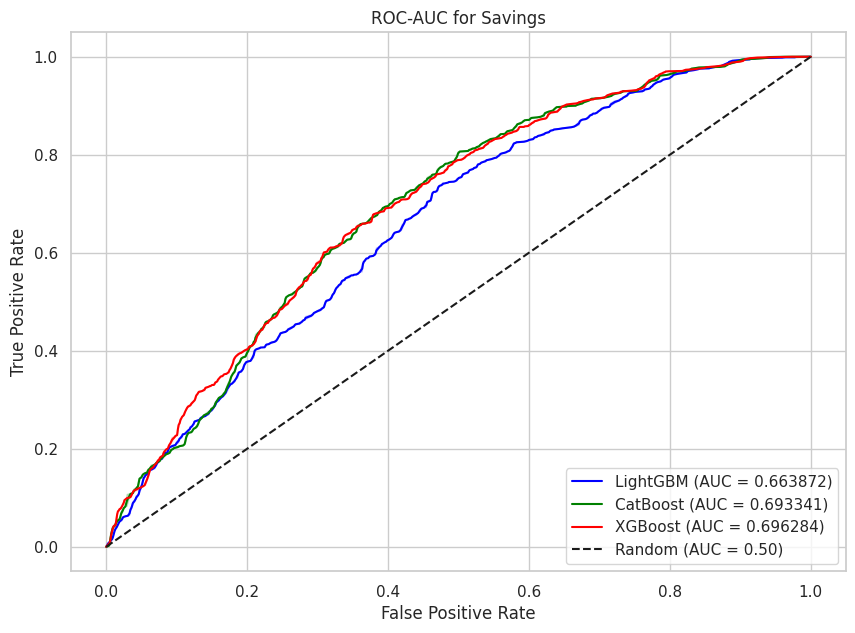

In [145]:
best_model_s_xg = XGBClassifier(**best_s_XGBoost)
best_model_s_xg.fit(X_train_s, y_train_s)
best_model_s_с = CatBoostClassifier(**best_s_CatBoost, verbose=250)
best_model_s_с.fit(X_train_s, y_train_s)
best_model_s_l = LGBMClassifier(**best_s_LightGBM, verbose=-1)
best_model_s_l.fit(X_train_s,y_train_s)
evaluate_models(best_model_s_l, best_model_s_с, best_model_s_xg, X_new_test_s, y_test_s,"Savings", pos_label=1)

In [148]:
best_m_XGBoost = optimizers(XGBClassifier, X_train_m, y_train_m, X_valid_m, y_valid_m)
best_m_CatBoost = optimizers_catboost(X_train_m, y_train_m, X_valid_m, y_valid_m, n_trials = 30)
best_m_LightGBM = optimize_lgbm(LGBMClassifier, X_train_m, y_train_m, X_valid_m, y_valid_m, n_trials = 500)

[I 2025-04-11 11:29:26,024] A new study created in memory with name: no-name-c00a87b8-edb5-4503-8d63-d6b6dd8cad68
[I 2025-04-11 11:29:26,689] Trial 0 finished with value: 0.9480253784505788 and parameters: {'n_estimators': 1046, 'max_depth': 11, 'learning_rate': 0.2043660054015562, 'subsample': 0.7513780312801067, 'colsample_bytree': 0.6792883274645081, 'min_child_weight': 9, 'gamma': 2.3919446697875326, 'reg_alpha': 1.473676765063786, 'reg_lambda': 2.427642247942238, 'scale_pos_weight': 4.670707638304572}. Best is trial 0 with value: 0.9480253784505788.
[I 2025-04-11 11:29:27,937] Trial 1 finished with value: 0.9537644701691897 and parameters: {'n_estimators': 511, 'max_depth': 13, 'learning_rate': 0.012277645521477974, 'subsample': 0.9883716165974177, 'colsample_bytree': 0.9674598658760286, 'min_child_weight': 9, 'gamma': 1.1926615761327235, 'reg_alpha': 4.879168108415529, 'reg_lambda': 4.581366866349947, 'scale_pos_weight': 8.989312103651898}. Best is trial 1 with value: 0.953764470

0:	learn: 0.6522218	total: 26.6ms	remaining: 5.71s
215:	learn: 0.1846667	total: 6.47s	remaining: 0us


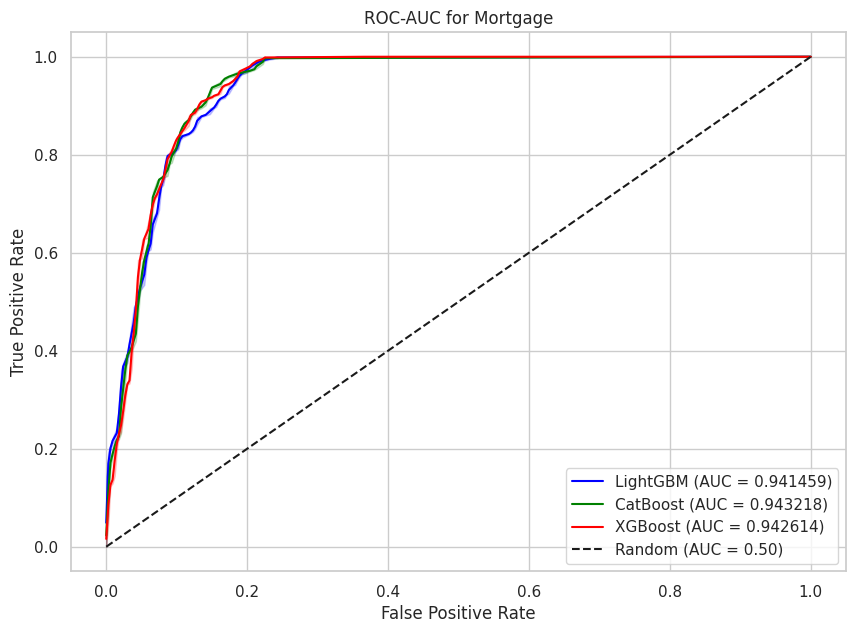

In [149]:
best_model_m_xg = XGBClassifier(**best_m_XGBoost)
best_model_m_xg.fit(X_train_m, y_train_m)
best_model_m_с = CatBoostClassifier(**best_m_CatBoost, verbose=250)
best_model_m_с.fit(X_train_m, y_train_m)
best_model_m_l = LGBMClassifier(**best_m_LightGBM, verbose=-1)
best_model_m_l.fit(X_train_m,y_train_m)
evaluate_models(best_model_m_l, best_model_m_с, best_model_m_xg, X_new_test_m, y_test_m,"Mortgage", pos_label=1)

In [150]:
best_p_XGBoost = optimizers(XGBClassifier, X_train_p, y_train_p, X_valid_p, y_valid_p)
best_p_CatBoost = optimizers_catboost(X_train_p, y_train_p, X_valid_p, y_valid_p, n_trials = 30)
best_p_LightGBM = optimize_lgbm(LGBMClassifier, X_train_p, y_train_p, X_valid_p, y_valid_p, n_trials = 500)

[I 2025-04-11 11:40:43,487] A new study created in memory with name: no-name-70a85a54-2135-424b-80b0-01eff1e36464
[I 2025-04-11 11:40:44,282] Trial 0 finished with value: 0.7549017344852602 and parameters: {'n_estimators': 916, 'max_depth': 5, 'learning_rate': 0.016796077427858713, 'subsample': 0.9190966920785142, 'colsample_bytree': 0.9473898681298892, 'min_child_weight': 9, 'gamma': 3.476273050808643, 'reg_alpha': 9.915747697861995, 'reg_lambda': 9.926964783596258, 'scale_pos_weight': 6.7265768602266585}. Best is trial 0 with value: 0.7549017344852602.
[I 2025-04-11 11:40:44,574] Trial 1 finished with value: 0.7586460462969069 and parameters: {'n_estimators': 572, 'max_depth': 14, 'learning_rate': 0.23718335800390614, 'subsample': 0.943018029544965, 'colsample_bytree': 0.7731851404776506, 'min_child_weight': 9, 'gamma': 4.17708303361529, 'reg_alpha': 3.8137499416455176, 'reg_lambda': 7.307535972986191, 'scale_pos_weight': 1.8333200571686623}. Best is trial 1 with value: 0.75864604629

0:	learn: 0.6510123	total: 9.21ms	remaining: 7.06s
250:	learn: 0.4223654	total: 1.75s	remaining: 3.6s
500:	learn: 0.4212802	total: 3.4s	remaining: 1.81s
750:	learn: 0.4203553	total: 5.07s	remaining: 108ms
766:	learn: 0.4203086	total: 5.18s	remaining: 0us


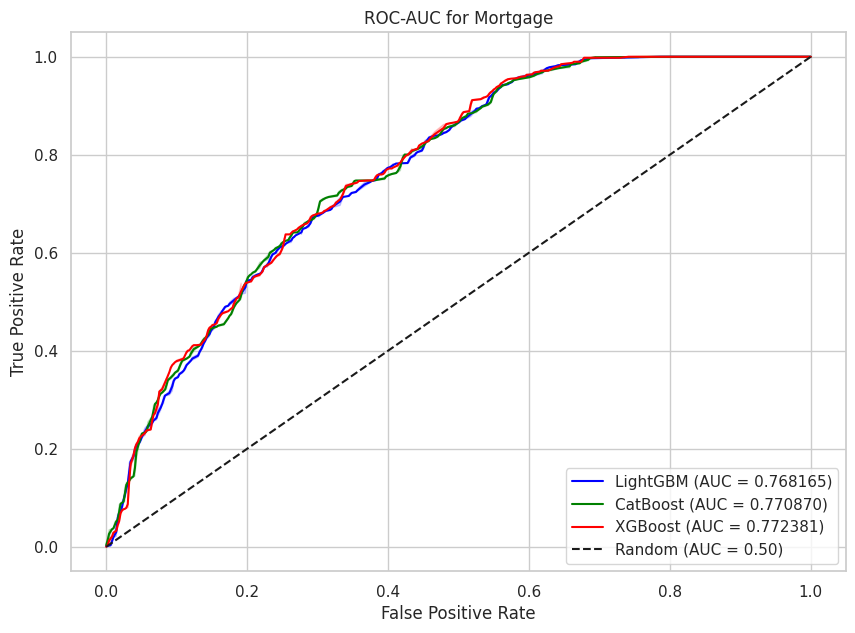

In [152]:
best_model_p_xg = XGBClassifier(**best_p_XGBoost)
best_model_p_xg.fit(X_train_p, y_train_p)
best_model_p_с = CatBoostClassifier(**best_p_CatBoost, verbose=250)
best_model_p_с.fit(X_train_p, y_train_p)
best_model_p_l = LGBMClassifier(**best_p_LightGBM, verbose=-1)
best_model_p_l.fit(X_train_p,y_train_p)
evaluate_models(best_model_p_l, best_model_p_с, best_model_p_xg, X_new_test_p, y_test_p,"Pension", pos_label=1)